In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
from face_tracking import data_collection, process_unknown_faces
import numpy as np
import albumentations as alb
import matplotlib.pyplot as plt
import time
from helpers import display_progressbar, preprocess, get_distribution_array, shuffle_arrays_in_sync, deprocess_image
from tensorflow.keras import mixed_precision

#### Configure GPU for training

In [2]:
# physical_devices = tf.config.list_physical_devices('GPU')
# print(physical_devices)
# if physical_devices:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)
#     tf.config.experimental.set_virtual_device_configuration(
#         physical_devices[0],
#         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
#     )
#     tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

#### Set paths Global Variables and get Face Detector

In [3]:
CELEB_ORIG_PATH = os.path.join('data', 'img_align_celeba')
UNKNOWN_FACES_PATH = os.path.join('data', 'unknown_faces')
KNOWN_FACES_PATH = os.path.join('data', 'known_faces')
KNOWN_FACE_PATH = os.path.join(KNOWN_FACES_PATH, 'stephen') # Change path for different identities

NUM_UNKNOWN_IMAGES = 10000

PERCENT_TRAINING = 80
PERCENT_TESTING = 10
PERCENT_VALIDATION = 10
NUM_AUGMENTATIONS_PER_IMAGE = 50
MODEL_INPUT_IMAGE_DIMENSIONS = (64, 64)
NUM_EPOCHS = 50

Face_Detector = cv2.dnn.readNetFromCaffe("do_not_delete/deploy.prototxt.txt",
                                             "do_not_delete/res10_300x300_ssd_iter_140000.caffemodel")

#### Process, Crop, and move celebrety faces to unknown faces path

In [4]:
if len(os.listdir(UNKNOWN_FACES_PATH)) > 0:
    print("Found files in directory already. To rerun, please empty " + UNKNOWN_FACES_PATH)
else:
    process_unknown_faces(input_path=CELEB_ORIG_PATH, output_path=UNKNOWN_FACES_PATH, face_detector=Face_Detector)    

Found files in directory already. To rerun, please empty data/unknown_faces


#### Capture, crop, and process images of target face

In [5]:
if len(os.listdir(KNOWN_FACE_PATH)) > 0:
    print("Found files in directory already. To rerun, please empty " + KNOWN_FACE_PATH)
else:
    data_collection(KNOWN_FACE_PATH, 10000)

Found files in directory already. To rerun, please empty data/known_faces/stephen


#### Partition Unaugmented Data

In [6]:
known_faces_dir = os.listdir(KNOWN_FACE_PATH)
unknown_faces_dir = os.listdir(UNKNOWN_FACES_PATH)
num_known_faces = len(known_faces_dir)
nun_unknown_faces = len(unknown_faces_dir)

process_known_face = get_distribution_array(num_known_faces, percent_training=PERCENT_TRAINING, percent_testing=PERCENT_TESTING, percent_validation=PERCENT_VALIDATION)
process_unknown_face = get_distribution_array(nun_unknown_faces, percent_training=PERCENT_TRAINING, percent_testing=PERCENT_TESTING, percent_validation=PERCENT_VALIDATION)

(training_images, training_labels), (test_images, test_labels), (val_images, val_labels) = ([], []), ([], []), ([], [])

t_orig = time.time()
total_photos = len(known_faces_dir)
total_processed = 0
t = time.time()
print("Processing {} known faces...".format(total_photos))
for i in range(len(known_faces_dir)):
    if process_known_face[i] == 0:
        training_images.append(deprocess_image(preprocess(input_path=os.path.join(KNOWN_FACE_PATH, known_faces_dir[i]), dimensions=MODEL_INPUT_IMAGE_DIMENSIONS)))
        training_labels.append(1)
    elif process_known_face[i] == 1:
        val_images.append(deprocess_image(preprocess(input_path=os.path.join(KNOWN_FACE_PATH, known_faces_dir[i]), dimensions=MODEL_INPUT_IMAGE_DIMENSIONS)))
        val_labels.append(1)
    else:
        test_images.append(deprocess_image(preprocess(input_path=os.path.join(KNOWN_FACE_PATH, known_faces_dir[i]), dimensions=MODEL_INPUT_IMAGE_DIMENSIONS)))
        test_labels.append(1)
    total_processed += 1
    t = display_progressbar(t1=t, t_orig=t_orig, total_photos=total_photos, total_processed=total_processed)
display_progressbar(t1=10, t_orig=0, total_photos=total_photos, total_processed=total_photos)
print("\r\nDone!")

t_orig = time.time()
total_photos = NUM_UNKNOWN_IMAGES
total_processed = 0
t = time.time()
print("Processing {} unknown faces...".format(total_photos))
for i in range(len(unknown_faces_dir)):
    if i > NUM_UNKNOWN_IMAGES:
        break
    if process_unknown_face[i] == 0:
        training_images.append(deprocess_image(preprocess(input_path=os.path.join(UNKNOWN_FACES_PATH, unknown_faces_dir[i]), dimensions=MODEL_INPUT_IMAGE_DIMENSIONS)))
        training_labels.append(0)
    elif process_unknown_face[i] == 1:
        val_images.append(deprocess_image(preprocess(input_path=os.path.join(UNKNOWN_FACES_PATH, unknown_faces_dir[i]), dimensions=MODEL_INPUT_IMAGE_DIMENSIONS)))
        val_labels.append(0)
    else:
        test_images.append(deprocess_image(preprocess(input_path=os.path.join(UNKNOWN_FACES_PATH, unknown_faces_dir[i]), dimensions=MODEL_INPUT_IMAGE_DIMENSIONS)))
        test_labels.append(0)
    total_processed += 1
    t = display_progressbar(t1=t, t_orig=t_orig, total_photos=total_photos, total_processed=total_processed)
display_progressbar(t1=10, t_orig=0, total_photos=total_photos, total_processed=total_photos)
print("\r\nDone!")
del known_faces_dir, unknown_faces_dir, num_known_faces, nun_unknown_faces, process_known_face, process_unknown_face, t_orig, total_photos, total_processed, t

Processing 5041 known faces...
5041/5041 [==============================] - ETA: 0:00
Done!
Processing 10000 unknown faces...
10000/10000 [==============================] - ETA: 0:00
Done!


#### Augment data

In [12]:
augmentor = alb.Compose([alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.3),
                         alb.RandomGamma(p=0.3),
                         alb.RGBShift(p=.3),
                         alb.VerticalFlip(p=0.2),
                         alb.Rotate(limit=20, p=.5, interpolation=cv2.INTER_LINEAR)])

l = len(training_images)
t_orig = time.time()
total_photos = l
total_processed = 0
t = time.time()
print("Augmenting {} images in training data...".format(total_photos))
for i in range(l):
    for j in range(NUM_AUGMENTATIONS_PER_IMAGE):
        img = (training_images[i]*255).astype(np.uint8)
        training_images.append(np.array(augmentor(image=img)['image'])/255)
        training_labels.append(training_labels[i])
    total_processed += 1
    t = display_progressbar(t1=t, t_orig=t_orig, total_photos=total_photos, total_processed=total_processed)
display_progressbar(t1=10, t_orig=0, total_photos=total_photos, total_processed=total_photos)
print("\r\nDone!")

l = len(test_images)
t_orig = time.time()
total_photos = l
total_processed = 0
t = time.time()
print("Augmenting {} images in test data...".format(total_photos))
for i in range(l):
    for j in range(NUM_AUGMENTATIONS_PER_IMAGE):
        img = (test_images[i]*255).astype(np.uint8)
        test_images.append(np.array(augmentor(image=img)['image'])/255)
        test_labels.append(test_labels[i])
    total_processed += 1
    t = display_progressbar(t1=t, t_orig=t_orig, total_photos=total_photos, total_processed=total_processed)
display_progressbar(t1=10, t_orig=0, total_photos=total_photos, total_processed=total_photos)
print("\r\nDone!")

l = len(val_images)
t_orig = time.time()
total_photos = l
total_processed = 0
t = time.time()
print("Augmenting {} images in validation data...".format(total_photos))
for i in range(l):
    for j in range(NUM_AUGMENTATIONS_PER_IMAGE):
        img = (val_images[i]*255).astype(np.uint8)
        val_images.append(np.array(augmentor(image=img)['image'])/255)
        val_labels.append(val_labels[i])
    total_processed += 1
    t = display_progressbar(t1=t, t_orig=t_orig, total_photos=total_photos, total_processed=total_processed)
display_progressbar(t1=10, t_orig=0, total_photos=total_photos, total_processed=total_photos)
print("\r\nDone!")

Augmenting 12072 images in training data...
12072/12072 [==============================] - ETA: 0:00
Done!
Augmenting 1432 images in test data...
1432/1432 [==============================] - ETA: 0:00
Done!
Augmenting 1538 images in validation data...
1538/1538 [==============================] - ETA: 0:00
Done!


#### Shuffling and converting to Numpy Arrays

In [13]:
print("Shuffling...")
(training_images, training_labels) = shuffle_arrays_in_sync(training_images, training_labels)
(test_images, test_labels) = shuffle_arrays_in_sync(test_images, test_labels)
(val_images, val_labels) = shuffle_arrays_in_sync(val_images, val_labels)
print("Converting to numpy arrays...")
training_images = np.array(training_images)
training_labels = np.array(training_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)
print("Done!")
print((training_images.shape, training_labels.shape))
print((test_images.shape, test_labels.shape))
print((val_images.shape, val_labels.shape))

Shuffling...
Converting to numpy arrays...
Done!
((615672, 64, 64, 3), (615672,))
((73032, 64, 64, 3), (73032,))
((78438, 64, 64, 3), (78438,))


#### Checking Data Preprocessing

In [1]:
training_images = iter(training_images)
training_labels = iter(training_labels)
test_images = iter(test_images)
test_labels = iter(test_labels)
val_images = iter(val_images)
val_labels = iter(val_labels)

NameError: name 'training_images' is not defined

0


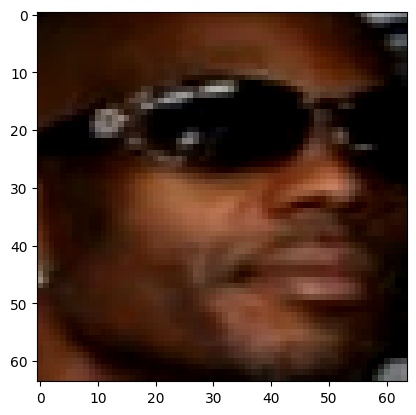

In [64]:
d = next(training_images) * 255
l = next(training_labels)
plt.imshow(d.astype(np.uint8))
print(l)

In [ ]:
d = next(test_images) * 255
l = next(test_labels)
plt.imshow(d.astype(np.uint8))
print(l)

In [ ]:
d = next(val_images) * 255
l = next(val_labels)
plt.imshow(d.astype(np.uint8))
print(l)